# Modelos Ocultos de Markov

Podemos entender un modelo oculto de Markov como la tupla: $$HMM = (\Sigma, S, A, \Pi, B)$$ donde $\Sigma$ es el alfabeto de observaciones, $S$ el alfabeto de emisiones, $(A, \Pi)$ un modelo del lenguaje sobre $S$ y, finalmente, $B$ la matriz de probabilidades de emisión.

Para construir este modelo necesitaremos diferentes librerías:

In [1]:
from collections import Counter, defaultdict
from itertools import chain
import numpy as np
from pickle import dump

#Funcion que crea un vocabulario de palabras con un indice numerico
def vocab():
    vocab = defaultdict()
    vocab.default_factory = lambda: len(vocab)
    return vocab    

#Funcion que pasa la cadena de simbolos a una secuencia con indices numericos
def text2numba(corpus, vocab):
    for doc in corpus:
        yield [vocab[w] for w in doc.strip().split()]

La idea es encontrar una función que sea capaz de mapear cadenas en un lenguaje $L_1$ a un lenguaje $L_2$. En este sentido, el primer lenguaje es el español y el segundo corresponde a las cadenas de etiqeutas POS.

In [2]:
obs = ['el salto de altura', 'yo salto la cuerda', 
         'ellos tomaban vino', 'ellos saltaban la cuerda']
ems = ['DA NC PP NC', 'DP V DA NC', 'DP V NC', 'DP V DA NC']

## Obtención de los vocabularios (alfabetos)

Ahora tenemos que indicar cuáles son las observaciones y cuáles los símbolos de emisión. Asimimso, asignaremos sus frecuencias y las probabilidades iniciales.

In [3]:
#Vocabulario de observaciones
obs_voc = vocab()
obs_cads = list(text2numba(obs,obs_voc))
print(obs_voc)

defaultdict(<function vocab.<locals>.<lambda> at 0x7f13ef91cee0>, {'el': 0, 'salto': 1, 'de': 2, 'altura': 3, 'yo': 4, 'la': 5, 'cuerda': 6, 'ellos': 7, 'tomaban': 8, 'vino': 9, 'saltaban': 10})


In [4]:
#Vocabulario de emisiones
ems_voc = vocab()
ems_cads = list(text2numba(ems,ems_voc))
print(ems_voc)

defaultdict(<function vocab.<locals>.<lambda> at 0x7f13ef91ce50>, {'DA': 0, 'NC': 1, 'PP': 2, 'DP': 3, 'V': 4})


Para obtener la matriz $B$ de probabilidades de emisión, requerimos saber que observaciones son generadas por qué emisiones. Para esto obtendremos pares de la forma $(o_i,s_j)$ con $o_i \in \Sigma$ y $s_j \in S)$. Esto es, si la observación $o_i$ está etiquetado con la emisión $s_i$ entonces lo tomaremos como un par de este conjunto.

In [5]:
#Pares de observaciones y sus etiquetas
obs_ems = list(chain(*[list(zip(c[0],c[1])) for c in zip(obs_cads,ems_cads)]))
print(obs_ems)

[(0, 0), (1, 1), (2, 2), (3, 1), (4, 3), (1, 4), (5, 0), (6, 1), (7, 3), (8, 4), (9, 1), (7, 3), (10, 4), (5, 0), (6, 1)]


Asimismo, para crear el modelo del lenguaje sobre $S$ requerimos llenar la matriz $A$ y el vector $\Pi$, para esto, a cada cadena de símbolos de emisión se le agregan los símbolos de inicio (BOS) y final (BOS).

In [6]:
#Indicamos las etiquetas a usar
EOS = '<EOS>'
BOS = '<BOS>'

#Cada etiqeuta se le asigna un indice numerico
BOS_IDX = max(ems_voc.values())+2
EOS_IDX = max(ems_voc.values())+1

#Se agregan estas etiqeutas al vocabulario
ems_voc[EOS] = EOS_IDX
ems_voc[BOS] = BOS_IDX

#A cada cadena se le agrega la etiqueta BOS al inicio y EOS al final
ems_cads = [[BOS_IDX] + cad + [EOS_IDX] for cad in ems_cads]

emsID = {v:k for k,v in ems_voc.items()}

print(ems_cads)

[[6, 0, 1, 2, 1, 5], [6, 3, 4, 0, 1, 5], [6, 3, 4, 1, 5], [6, 3, 4, 0, 1, 5]]


A partir de las cadenas de emisiones (que pertenencen a $S^*$) obtenemos los bigramas que se atestiguaron en el corpus.

In [7]:
#Bigramas a partir de las cadenas de emisiones
ems_bigrams = list(chain(*[ zip(cad,cad[1:]) for cad in ems_cads] ))
print(ems_bigrams)

[(6, 0), (0, 1), (1, 2), (2, 1), (1, 5), (6, 3), (3, 4), (4, 0), (0, 1), (1, 5), (6, 3), (3, 4), (4, 1), (1, 5), (6, 3), (3, 4), (4, 0), (0, 1), (1, 5)]


## Estimación del modelo oculto de Markov

Una vez obtenido los vocabularios, así como sus indices, así como los pares de observaciones y sus emisiones y los bigramas de emisiones, podemos determinar el modelo; es decir, estimaremos las probabilidades que llenarán las marices $A$, $\Pi$ y $B$.

In [8]:
#Longitud del vocabulario de emisiones
N = len(ems_voc)
#Longitud del vocabulario de observaciones
M = len(obs_voc)

#ems language model
Pi = np.zeros(N-2)
A = np.zeros((N-2,N-1))

#Prob ems
B = np.zeros((M,N-2))

Para obtener el modelo del lenguaje sobre $S$ estimaremos los siguientes elementos:
* La matriz de transiciones:

$$A=(a_{ij}) = p(s_j|s_i)  = \frac{\#(s_i s_j)+1}{\#(s_i) + N}$$

* El vector de iniciales:

$$\Pi = (\pi_{i}) = p(s_i) = \frac{\#(BOS, s_i)+1}{\#(BOS)+N}$$

In [9]:
#Frecuencia de bigramas de emisiones
frec_ems = Counter(ems_bigrams)

#Llenado de las frecuencias
for em, frec_em in frec_ems.items():
    if em[0] == BOS_IDX:
        Pi[em[1]] = frec_em
    else:
        A[em] = frec_em

In [10]:
#Sommothing
A = ((A.T+1)/(A+1).sum(1)).T
Pi = (Pi+1)/(Pi+1).sum(0)

In [11]:
#Comprobar que las sumas sean 1
print(A.sum(1))
print(Pi.sum(0))

[1. 1. 1. 1. 1.]
1.0


Para obtener la matriz $B$, usaremos la siguiente función:

$$B = (b_{ij}) = p(o_j|s_i) = \frac{\#(o_j, s_i)+1}{\#(s_i)+M}$$

In [12]:
#Frecuencia de pares de observaciones y emisiones
frec_obs = Counter(obs_ems)

#Llenado con las frecuencias
for ob, frec_ob in frec_obs.items():
    B[ob] = frec_ob

In [13]:
#Smoothing
B = ((B+1).T/(B+1).sum(1)).T

In [14]:
#Comprobar que se sume 1
print(B.sum(1))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## Calculo de probabilidades

El modelo oculto de Markov (HMM) que hemos estimado permite el cálculo de diferentes probabilidades. En primer lugar, nos permite calcular probabilidades como en un modelo del lenguaje sobre las etiquetas $S$.

In [15]:
def prob_cad(string):
    #Separar
    seq = string.split()
    #Prob inicial
    p = Pi[ems_voc[seq[0]]]
    
    #Probs de transición
    for i in range(len(seq)):
        if i != len(seq)-1:
            p *= A[ ems_voc[seq[i]], ems_voc[seq[i+1]] ]
        else:
            pass
    
    return p

In [16]:
print(prob_cad('DA NC V'))

0.008978675645342311


Asimismo, nos puede ayudar a predecir cuál es el elemento siguiente en una cadena, dada la historia.

In [17]:
def next_word(string):
    #Palabras en la cadena
    sent = [ems_voc[w] for w in string.split()]
    #Los elementos previos
    prev_gram = sent[-1]
    #Se obtiene probabilidad d ela cadena previa
    p = prob_cad(string)
    #Se obtienen las probabilidades de los elementps subsiguientes
    #Se obtiene el máximo de estas probabilidades
    next = np.argmax(p*A[prev_gram])
    
    return emsID[next]

In [18]:
print(next_word('DA NC V'))

DA


Más aún, podemos utilizar las propiedades del grafo que definen para obtener la probabilidad:

$$p(s_1,...,s_T|o_1,...,o_T) \propto p(s_1)\prod_{t=2}^T p(o_t|s_t)p(s_t|s_{t-1})$$

In [19]:
ej_text = 'yo salto la cuerda'
ej_tags = 'DP V DA NC'

In [20]:
transit = list(zip( ej_tags.split(),ej_tags.split()[1:] ))
ejemplo = list(zip( ej_text.split(),ej_tags.split() ))

print(transit)
print(ejemplo)

[('DP', 'V'), ('V', 'DA'), ('DA', 'NC')]
[('yo', 'DP'), ('salto', 'V'), ('la', 'DA'), ('cuerda', 'NC')]


In [21]:
import networkx as nx 
import matplotlib.pyplot as plt

G1 = nx.Graph()
G1.add_edges_from(ejemplo+transit)

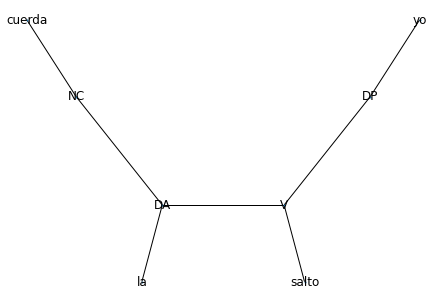

In [22]:
nx.draw_spectral(G1, with_labels=True, node_size=1)
plt.show()

También, dado una secuencia de observaciones, podemos estimar la mejor secuencia de etiquetas a partir de:

$$\arg\max_{s_1,...,s_N} p(s_1)\prod_{t=2}^T p(o_t|s_t)p(s_t|s_{t-1})$$

In [23]:
def prob_conj(text, tags):
    tags_bigrs = list(zip( tags.split(), tags.split()[1:] ))
    text_pairs = list(zip( text.split(), tags.split() ))
    p = Pi[ ems_voc[tags_bigrs[0][0]] ]
    
    for bi in tags_bigrs:
        p *= A[ ems_voc[bi[0]], ems_voc[bi[1]] ]
        
    for t in text_pairs:
        p *= B[ obs_voc[t[0]], ems_voc[t[1]] ]
    
    return p

In [24]:
print(prob_conj(ej_text,ej_tags))

0.0005119037620927265


Cómo obtener el mejor etiquetado dado una secuencia de observaciones.

In [25]:
from itertools import product

text1 = 'yo salto el salto de altura ellos saltaban'

candidatos = list(product( list(ems_voc.keys())[:-2], repeat=len(text1.split()) ))
print(len(candidatos))
print(candidatos[:5])

390625
[('DA', 'DA', 'DA', 'DA', 'DA', 'DA', 'DA', 'DA'), ('DA', 'DA', 'DA', 'DA', 'DA', 'DA', 'DA', 'NC'), ('DA', 'DA', 'DA', 'DA', 'DA', 'DA', 'DA', 'PP'), ('DA', 'DA', 'DA', 'DA', 'DA', 'DA', 'DA', 'DP'), ('DA', 'DA', 'DA', 'DA', 'DA', 'DA', 'DA', 'V')]


In [26]:
%%time
#Guarda los candidatos
temp = np.zeros(len(candidatos))

#Obtiene la probabilidad para todos los candidatos
for i,cand in enumerate(candidatos):
    cand_tags = ' '.join(cand)
    temp[i] = prob_conj(text1, cand_tags )

#El candidato que maximiza la probabilidad
ArgMax = np.argmax(temp)

print(text1)
print(candidatos[ArgMax])

yo salto el salto de altura ellos saltaban
('DP', 'V', 'DA', 'NC', 'PP', 'NC', 'DP', 'V')
CPU times: user 4.37 s, sys: 0 ns, total: 4.37 s
Wall time: 4.36 s


## Aplicación del algoritmo de Viterbi

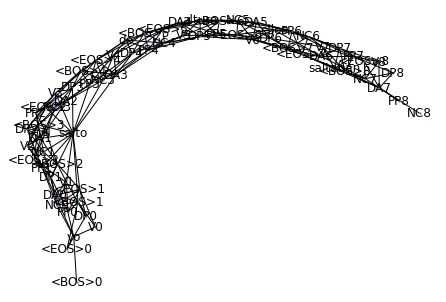

In [27]:
from itertools import combinations

edges = []
for t,w in enumerate(text1.split()):
    conn = [(s+str(t),w) for s in ems_voc]
    edges.append(conn)
    
    edges.append( [(s+str(t),st+str(t+1)) for s,st in combinations(ems_voc,2)] )
    
edges = list( chain(*edges) )
graph = nx.Graph()
graph.add_edges_from(edges)

nx.draw(graph, with_labels=True, node_size=1)
plt.show()

In [28]:
tags = {v:k for k,v in ems_voc.items()}

In [29]:
%%time
#Inicialización
obs_text = text1.split()
d = np.zeros((len(obs_text),len(ems_voc)-2))
d[0] = Pi*B[ obs_voc[obs_text[0]] ]

phi = np.zeros((len(obs_text),len(ems_voc)-2))

for t,o in enumerate(obs_text):
    probs = A[:,:-1]*np.outer(B[obs_voc[o]],d[t])
    phi[t] = np.argmax(probs,axis=0)
    
    if t != len(obs_text)-1:
        d[t+1] = np.max(probs,axis=0)

    
#print(d,phi)

#BACKWARD
tags_prop = []
for j in range(len(obs_text)):
    T = len(obs_text)-j-1
    if j == 0:
        tags_prop.append(np.argmax( d[T]))
    else:        
        tags_prop.append( int(phi[T][tags_prop[j-1]]) )
  
print('Texto orig:',text1)
print('Viterbi:', [tags[w] for w in tags_prop][::-1])   
#print('Combinar:',candidatos[ArgMax])

Texto orig: yo salto el salto de altura ellos saltaban
Viterbi: ['DP', 'V', 'DA', 'NC', 'PP', 'NC', 'DP', 'V']
CPU times: user 1.4 ms, sys: 330 µs, total: 1.73 ms
Wall time: 1.08 ms
